In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dowhy import CausalModel
import warnings
warnings.filterwarnings("ignore")

def default_params():
    return {
        'causal_dataset': '../data/causal_analysis/causal_data.csv',
        'treatment_column': 'treatment',
        'outcome_column': 'output',
        'confounder_columns': [
            'code_number_tokens',
            'code_complexity',
            'code_num_identifiers',
            'code_num_strings',
            'code_num_comments',
            'docstring_num_lines',
            'docstring_num_words',
            'docstring_num_sentences'
        ],
        'causal_results_output': '../data/causal_analysis/causal_effects.csv',
        'causal_model_path': './causal_model.png'
    }

params = default_params()

print("Params loaded:")
params


Matplotlib is building the font cache; this may take a moment.
C:\Users\sakre\Desktop\GenAI_Kaggle_Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Params loaded:


{'causal_dataset': '../data/causal_analysis/causal_data.csv',
 'treatment_column': 'treatment',
 'outcome_column': 'output',
 'confounder_columns': ['code_number_tokens',
  'code_complexity',
  'code_num_identifiers',
  'code_num_strings',
  'code_num_comments',
  'docstring_num_lines',
  'docstring_num_words',
  'docstring_num_sentences'],
 'causal_results_output': '../data/causal_analysis/causal_effects.csv',
 'causal_model_path': './causal_model.png'}

In [2]:
df = pd.read_csv(params['causal_dataset'])
print("Loaded:", df.shape)
df.head()


Loaded: (60000, 13)


,index,input_code,output_docstring,code_number_tokens,code_complexity,code_num_identifiers,code_num_strings,code_num_comments,docstring_num_lines,docstring_num_words,docstring_num_sentences,output,treatment
0,37631,"def p_FuncDef(p):\n p[0] = FuncDef(p[2], p[...",FuncDef : DEF RefModifier INDENTIFIER LPARENT ...,10,1,0,0,0,1,12,0,0,0
1,172041,def reload(self):\n new_model = self.collec...,Load this object from the server again and upd...,8,1,2,0,0,1,15,1,1,0
2,107093,"def path_helper(self, path, view, **kwargs):\n...",Path helper for Flask - RESTy views .,50,3,7,7,0,1,8,1,0,0
3,165741,"def _GeneratePathString(self, mediator, pathsp...",Generates a string containing a pathspec and i...,24,2,2,2,0,1,10,1,0,0
4,76152,"def knot_insertion_kv(knotvector, u, span, r):...",Computes the knot vector of the rational / non...,53,5,2,0,0,1,16,1,0,0


In [3]:
required_cols = (
    params['confounder_columns']
    + [params['treatment_column'], params['outcome_column']]
)

missing = [c for c in required_cols if c not in df.columns]

if missing:
    raise ValueError("Missing required columns: " + str(missing))

print("All required columns present.")


All required columns present.


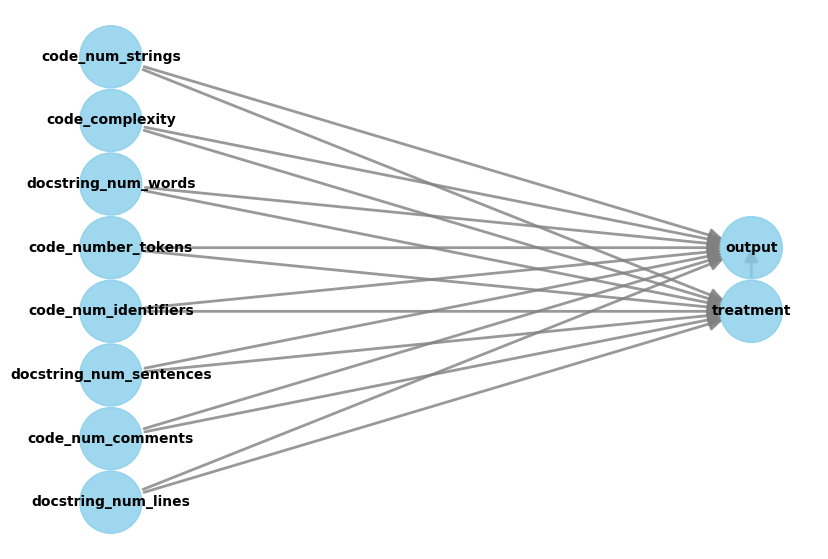

Saved SCM graph (networkx) → ./causal_model.png


In [5]:
from dowhy.utils.networkx_plotting import plot_causal_graph_networkx

graph = model._graph._graph  # extract the underlying networkx graph

plot_causal_graph_networkx(
    graph,
    filename=params['causal_model_path'],
    figure_size=(10, 7)
)

print("Saved SCM graph (networkx) →", params['causal_model_path'])


In [6]:
identified_estimand = model.identify_effect()
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[output|docstring_num_lines,code_num_comments,docstring_num_sent ↪
d[treatment]                                                                   ↪

↪                                                                              ↪
↪ ences,code_num_identifiers,code_number_tokens,docstring_num_words,code_compl ↪
↪                                                                              ↪

↪                         
↪ exity,code_num_strings])
↪                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→output then P(output|treatment,docstring_num_lines,code_num_comments,docstring_num_sentences,code_num_identifiers,code_number_tokens,docstring_num_words,code_complexity,code_num_strings,U) = P(output|treatment,docstring_num_lines,code_num_comments,docstring_

In [7]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("Estimated ATE:", estimate.value)
estimate


Estimated ATE: -0.49156666666686777


In [8]:
ref_results = []

# Random Common Cause
r1 = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)
ref_results.append(("random_common_cause", r1.new_effect))

# Placebo Treatment
r2 = model.refute_estimate(
    identified_estimand, estimate, method_name="placebo_treatment_refuter"
)
ref_results.append(("placebo_treatment", r2.new_effect))

# Data Subset Refuter
r3 = model.refute_estimate(
    identified_estimand, estimate, method_name="data_subset_refuter"
)
ref_results.append(("data_subset", r3.new_effect))

ref_results


[('random_common_cause', np.float64(-0.4915691071481967)),
 ('placebo_treatment', np.float64(-0.00014433073726697276)),
 ('data_subset', np.float64(-0.49146157356809944))]

In [9]:
rows = []

rows.append({
    "metric": "ATE",
    "method": "linear_regression",
    "value": estimate.value
})

for name, val in ref_results:
    rows.append({
        "metric": "refutation",
        "method": name,
        "refuted_value": val
    })

effects_df = pd.DataFrame(rows)
os.makedirs("../data/causal_analysis", exist_ok=True)
effects_df.to_csv(params['causal_results_output'], index=False)

print("Saved causal_effects.csv →", params['causal_results_output'])
effects_df


Saved causal_effects.csv → ../data/causal_analysis/causal_effects.csv


,metric,method,value,refuted_value
0,ATE,linear_regression,-0.491567,NaN
1,refutation,random_common_cause,NaN,-0.491569
2,refutation,placebo_treatment,NaN,-0.000144
3,refutation,data_subset,NaN,-0.491462
